<a href="https://colab.research.google.com/github/obiedeh/QPSK-Wireless-Link-Simulator/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###main.py – Run simulations and plots

=== QPSK over AWGN ===
SNR =  0 dB | BER = 5.0168e-01
SNR =  2 dB | BER = 4.9658e-01
SNR =  4 dB | BER = 4.9352e-01
SNR =  6 dB | BER = 4.9636e-01
SNR =  8 dB | BER = 4.9816e-01
SNR = 10 dB | BER = 5.0080e-01
SNR = 12 dB | BER = 4.9924e-01
SNR = 14 dB | BER = 5.0072e-01
SNR = 16 dB | BER = 5.0044e-01


SNR = 18 dB | BER = 4.9580e-01
SNR = 20 dB | BER = 4.9848e-01

=== QPSK over Rayleigh flat fading ===
SNR =  0 dB | BER = 5.0240e-01
SNR =  2 dB | BER = 4.9716e-01
SNR =  4 dB | BER = 5.0712e-01
SNR =  6 dB | BER = 4.9936e-01
SNR =  8 dB | BER = 5.0364e-01
SNR = 10 dB | BER = 4.9788e-01
SNR = 12 dB | BER = 4.9824e-01
SNR = 14 dB | BER = 5.0232e-01


SNR = 16 dB | BER = 5.0212e-01
SNR = 18 dB | BER = 4.9576e-01
SNR = 20 dB | BER = 5.0040e-01

Example BER at 10 dB (AWGN): 4.9550e-01


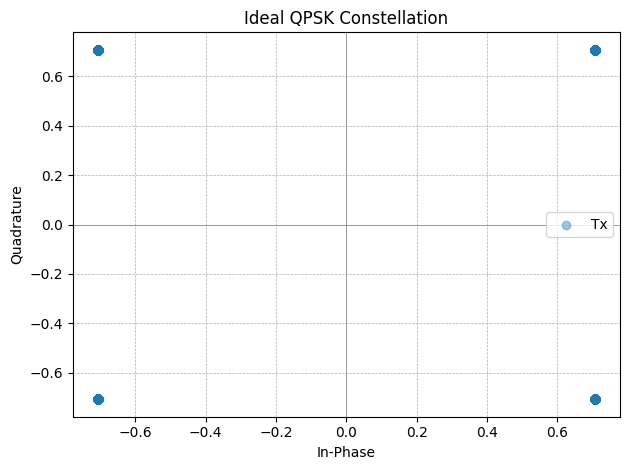

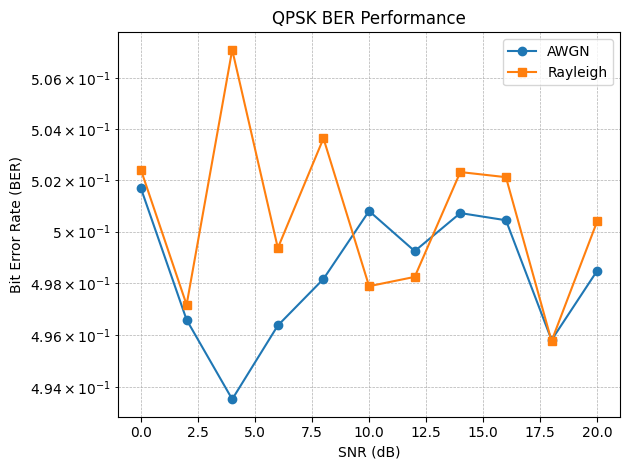

In [ ]:
import numpy as np
import os, sys
sys.path.append(os.getcwd())
from qpsk_modem import qpsk_modulate, qpsk_demodulate
from channel import apply_channel
from plots import plot_constellation, plot_ber

def simulate_qpsk_link(num_bits=10000,
                       sps=8,
                       beta=0.35,
                       snr_db=10.0,
                       fading=False):
    """
    Simulate a single QPSK transmission and return BER and diagnostics.
    """
    # Generate random bits
    bits_tx = np.random.randint(0, 2, num_bits)

    # Modulate
    tx_signal, syms_tx, h_rrc = qpsk_modulate(bits_tx, sps=sps, beta=beta)

    # Channel
    rx_signal, h = apply_channel(tx_signal, snr_db=snr_db, fading=fading)

    # Demodulate
    num_syms = len(syms_tx)
    bits_rx = qpsk_demodulate(rx_signal, h_rrc, sps, num_syms, channel_coef=h)
    bits_rx = bits_rx[:len(bits_tx)]  # align length

    # BER
    bit_errors = np.sum(bits_tx != bits_rx)
    ber = bit_errors / len(bits_tx)

    return ber, bits_tx, bits_rx, syms_tx, h, rx_signal

def ber_curve(snr_db_list,
              num_bits=50000,
              sps=8,
              beta=0.35,
              fading=False):
    bers = []
    for snr in snr_db_list:
        ber, *_ = simulate_qpsk_link(
            num_bits=num_bits,
            sps=sps,
            beta=beta,
            snr_db=snr,
            fading=fading,
        )
        print(f"SNR = {snr:2d} dB | BER = {ber:.4e}")
        bers.append(ber)
    return np.array(bers)

if __name__ == "__main__":
    # Config
    sps = 8
    beta = 0.35
    snr_range = list(range(0, 21, 2))

    print("=== QPSK over AWGN ===")
    ber_awgn = ber_curve(snr_range, sps=sps, beta=beta, fading=False)

    print("\n=== QPSK over Rayleigh flat fading ===")
    ber_rayleigh = ber_curve(snr_range, sps=sps, beta=beta, fading=True)

    # Quick constellation sanity-check at moderate SNR
    ber_example, _, _, syms_tx, _, _ = simulate_qpsk_link(
        num_bits=4000,
        sps=sps,
        beta=beta,
        snr_db=10,
        fading=False,
    )
    print(f"\nExample BER at 10 dB (AWGN): {ber_example:.4e}")
    plot_constellation(syms_tx, title="Ideal QPSK Constellation")

    # BER plot
    plot_ber(snr_range, ber_awgn, ber_rayleigh)
